In [1]:
import os
import re
import spacy 
from spacy import displacy
import json
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

In [10]:
# load csv data
tweet_df = pd.read_csv('tweet_labelled.csv')
print(tweet_df.head())

# drop rows with label = 0
tweet_df = tweet_df[tweet_df['label'] != 0]
print(tweet_df.head())

   id  label                                              tweet
0   1      0  `- This is not ``creative``.  Those are the di...
1   2      0  `  :: the term ``standard model`` is itself le...
2   3      0    True or false, the situation as of March 200...
3   4      0   Next, maybe you could work on being less cond...
4   5      0               This page will need disambiguation. 
      id  label                                              tweet
52    53      1  `  :Click on my ``Annoying Users`` link! I gue...
60    61      1          Iraq is not good  ===  ===  USA is bad   
121  122      1  `  Buddha - ``Some suggest that victims should...
207  208      1    ____ fuck off you little asshole. If you wan...
351  352      1       i have a dick, its bigger than yours! hahaha


In [12]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    text = re.sub(r'\W*\b(?!no)\w{1,2}\b', '', text)
    stop_words = set(stopwords.words('english'))
    more_stopwords = ('user', 'url', 'as', "like", "get", "people", "know", "would", "stop", "one")
    stop_words.update(more_stopwords)
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return words

In [13]:
data = []

tweet_df['processed_tweet'] = tweet_df['tweet'].apply(preprocess_text)
tweet_df.drop(columns=['tweet'], inplace=True)
print(tweet_df["processed_tweet"])
print("Finished preprocessing text")

texts, article = [], []
print("Performing topic modelling")
for fact in tweet_df['processed_tweet']:
    for word in fact:
        article.append(word)
        
    texts.append(article)
    article = []

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

#initialize parameters
best_coherence = -1
best_lda = None
for num_topics in range(8, 9, 1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42)
    
    # Get coherence score for each loop
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_score}")
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_topic = num_topics
print(f"Best no of topic: {best_topic} and Best Coherence Score: {best_coherence}")

#use the best model (result from above codes: 10 topics)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=best_topic,
                                                random_state=42)

topics_matrix = lda_model[corpus]
topics = []
# Iterate over each document's topic distribution
# Get the topic with the highest probability
for doc in topics_matrix:
    topic = max(doc, key=lambda x: x[1])[0]
    topics.append(topic)

tweet_df['tweet_topics'] = topics
tweet_df = tweet_df.reset_index(drop=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

52        [click, annoying, user, link, guess, massachus...
60                                   [iraq, good, usa, bad]
121       [buddha, suggest, victim, referred, additional...
207       [____, fuck, little, asshole, want, talk, huma...
351                                  [dick, bigger, hahaha]
                                ...                        
842316    [another, dumb, comment, put, america, first, ...
842317    [use, google, simpleton, word, spelled, dense,...
842325    [obviously, comic, book, read, done, good, bet...
842328    [give, jamal, jrk, never, possibly, waste, tim...
842333    [leave, email, phone, number, maybe, twit, mee...
Name: processed_tweet, Length: 133690, dtype: object
Finished preprocessing text
Performing topic modelling
Number of topics: 8, Coherence Score: 0.4851459388953354
Best no of topic: 8 and Best Coherence Score: 0.4851459388953354


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.350002 -0.043398       1        1  41.700200
7     -0.339580 -0.011437       2        1  20.474882
3      0.152872 -0.258986       3        1   8.124595
6      0.100525 -0.110340       4        1   6.647742
4      0.162581  0.022339       5        1   6.372816
2      0.121842  0.041017       6        1   5.926552
1      0.033865  0.232731       7        1   5.759952
0      0.117897  0.128074       8        1   4.993262, topic_info=          Term          Freq         Total Category  logprob  loglift
59        fuck  29088.000000  29088.000000  Default  30.0000  30.0000
307      bitch  27777.000000  27777.000000  Default  29.0000  29.0000
398    fucking  18559.000000  18559.000000  Default  28.0000  28.0000
247         as  17657.000000  17657.000000  Default  27.0000  27.0000
70        shit  13934.000000  13934.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3950   smoking    352.794936    356.638750   Topic8  -5.8555   2.9862
89990      udc   1623.119067   2054.662790   Topic8  -4.3292   2.7613
90019     ufef    457.328955    676.635879   Topic8  -5.5959   2.6054
222       rule    502.759109    896.631175   Topic8  -5.5012   2.4185
890       keep    623.757480   3491.092070   Topic8  -5.2856   1.2749

[436 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
4626       5  0.002440    abortion
4626       8  0.995428    abortion
2827       2  0.996808      africa
2827       5  0.001086      africa
2988       1  0.997398     african
...      ...       ...         ...
8671       5  0.001015       young
8671       7  0.886134       young
8671       8  0.111655       young
25790      3  0.991942  yourselfgo
25790      5  0.003318  yourselfgo

[1242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 4, 7, 5, 3, 2, 1])

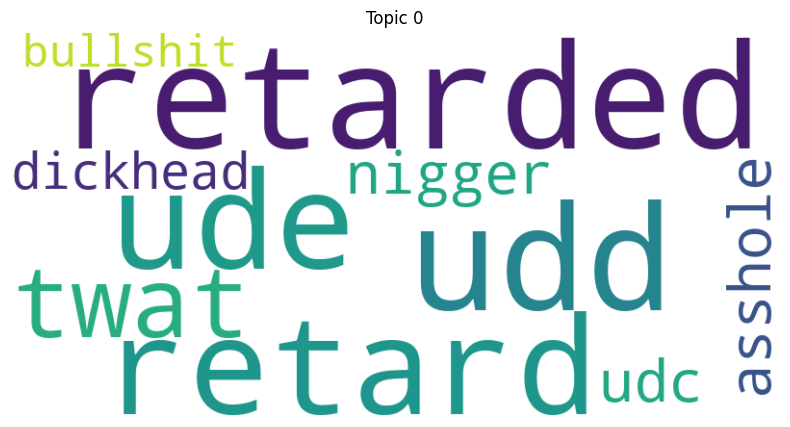

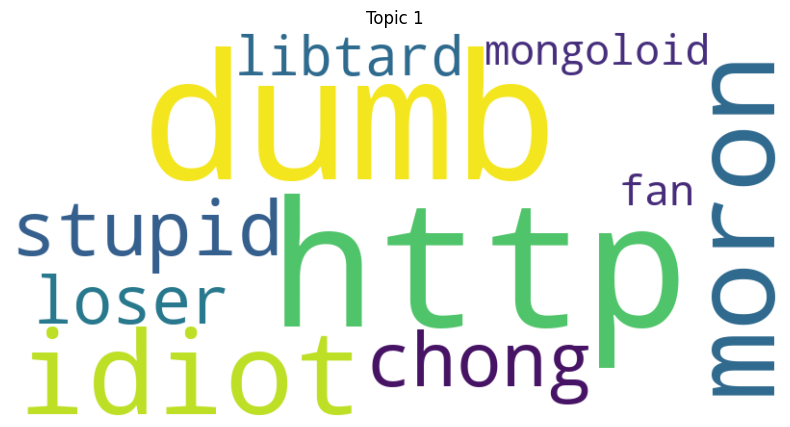

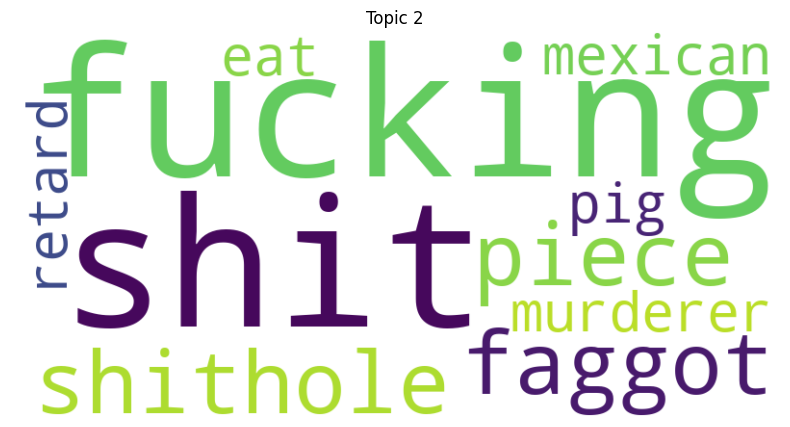

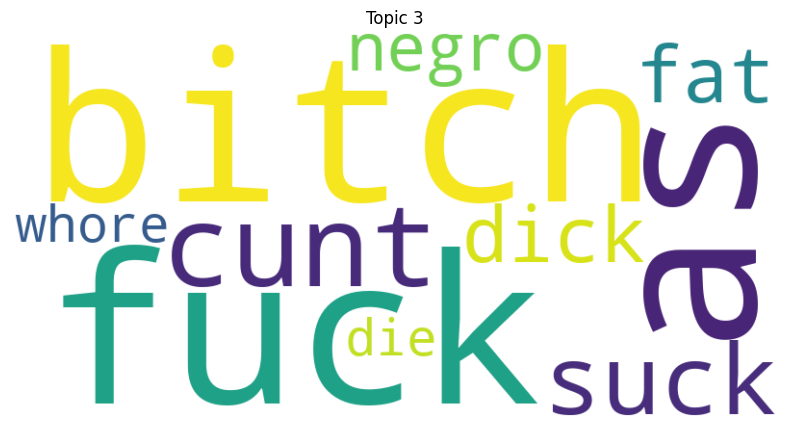

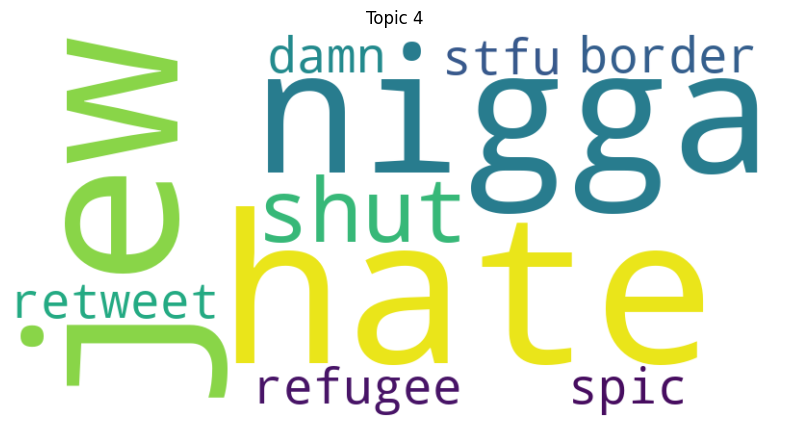

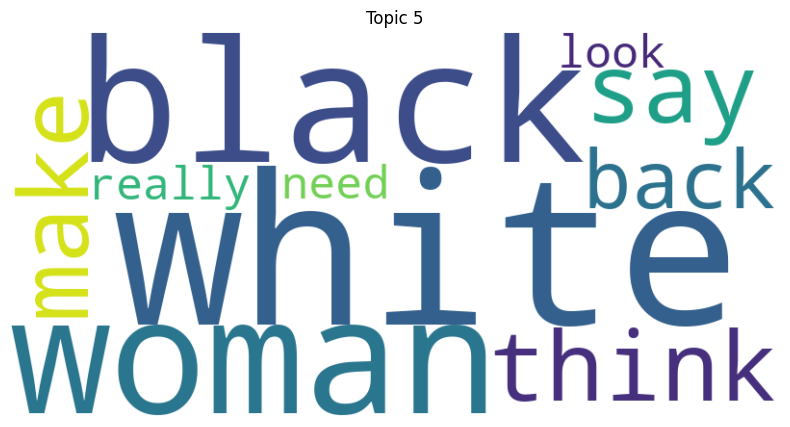

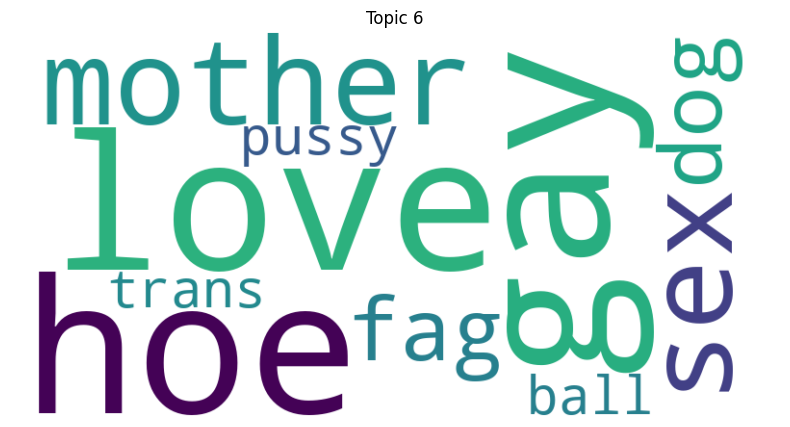

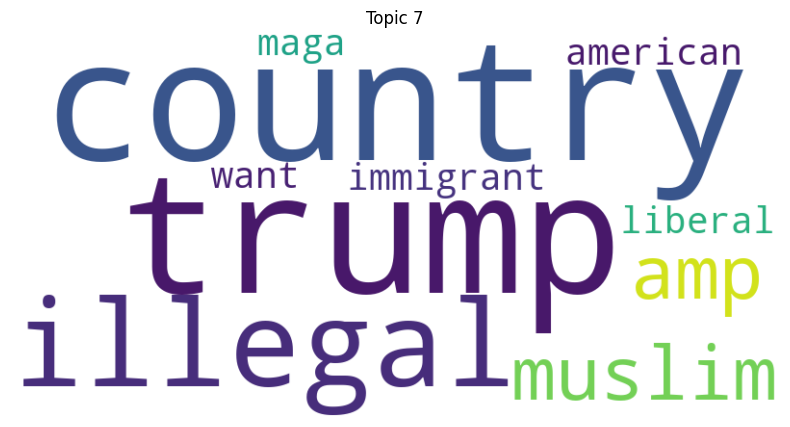

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def get_topic_words(lda_model, num_words=10):
    topic_words = {}
    for i in range(lda_model.num_topics):
        words = [word for word, _ in lda_model.show_topic(i, topn=num_words)]
        topic_words[i] = words
    return topic_words

def plot_wordcloud(topic_words):
    for i in range(len(topic_words)):
        word_counts = Counter(topic_words[i])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic {i}")
        plt.show()

topic_words = get_topic_words(lda_model)
plot_wordcloud(topic_words)


In [7]:
# save to csv
tweet_df.to_csv('tweet_labelled_cleaned_topics.csv', index=False)